In [1]:
import sys
sys.path.append("/Users/shin/work/deep/keras/pix2pix")

In [146]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense,Reshape, Input,merge
from keras.layers.merge import concatenate,average
from keras.layers.core import Activation, Dropout, Flatten,Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D,Conv2D, MaxPooling2D,Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from math import ceil
from PIL import Image
import matplotlib.pyplot as plt
from facade_dataset2 import load_dataset
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

In [3]:
train_d = load_dataset(dataDir = "../dataset/base/", data_range=(1,300))

load dataset start
     from: ../dataset/base/
load dataset done


In [4]:
def CBR(ch,shape,bn=True,sample='down',activation=LeakyReLU, dropout=False):
    model = Sequential()
    if sample=='down':
        model.add(Conv2D(filters=ch, kernel_size=(4,4), strides=2, padding='same',input_shape=shape))
    else:
        model.add(Conv2DTranspose(filters=ch, kernel_size=(4,4), strides=2, padding='same',input_shape=shape))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))
    if activation == LeakyReLU:
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation('relu'))
    
    return model

In [5]:
def PatchGan(patch_size=4):
    p = patch_size
    input1 = Input(shape=(p,p,12))
    input2 = Input(shape=(p,p,3))
    x1 = CBR(32,(p,p,12))(input1)
    x2 = CBR(32,(p,p,3))(input2)
    x = concatenate([x1,x2])
    x = CBR(128,(int(p/2),int(p/2),64))(x)
    x = CBR(256,(int(int(p/2)/2),int(int(p/2)/2),128))(x)
    x = Flatten()(x)
    output = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=[input1,input2], outputs=output)
    return model

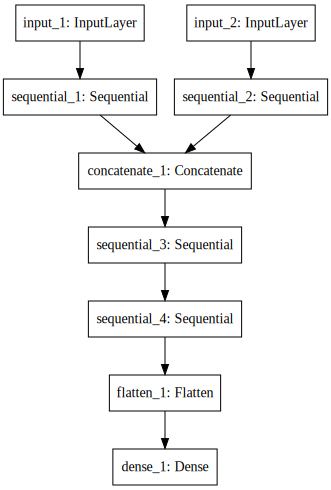

In [6]:
model = PatchGan(4)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4, 4, 12)      0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 4, 4, 3)       0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 2, 2, 32)      6304        input_1[0][0]                    
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 2, 2, 32)      1696        input_2[0][0]                    
___________________________________________________________________________________________

In [72]:
def discriminator(patch_size=4):
    h = 256
    w = 256
    ph = patch_size
    pw = patch_size
    gen_output = Input(shape=(h,w,3))
    label_input = Input(shape=(h,w,12))
    list_row_idx = [(i * ph, (i + 1) * ph) for i in range(int(h / ph))]
    list_col_idx = [(i * pw, (i + 1) * pw) for i in range(int(w / pw))]
    pg = PatchGan(patch_size)
    pg_list = []
    
    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            gen_patch =  Lambda(lambda x: x[:,row_idx[0]:row_idx[1],col_idx[0]:col_idx[1],:])(gen_output)
            img_patch =  Lambda(lambda x: x[:,row_idx[0]:row_idx[1],col_idx[0]:col_idx[1],:])(label_input)
            x = pg([img_patch,gen_patch])
            pg_list.append(x)
    x = concatenate(pg_list)
    # output = Lambda(lambda x: K.mean(x,axis=[1]),output_shape = [1,])(x)
    output = Dense(1,activation = 'sigmoid')(x)
    model = Model(inputs =[label_input,gen_output], outputs = output)
    
    return model

In [149]:
def discriminator3(patch_size=4):
    h = 256
    w = 256
    ph = patch_size
    pw = patch_size
    gen_output = Input(shape=(h,w,3))
    label_input = Input(shape=(h,w,12))
    list_row_idx = [(i * ph, (i + 1) * ph) for i in range(int(h / ph))]
    list_col_idx = [(i * pw, (i + 1) * pw) for i in range(int(w / pw))]
    pg = PatchGan(patch_size)
    pg_list = []
    
    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            gen_patch =  Lambda(lambda x: x[:,row_idx[0]:row_idx[1],col_idx[0]:col_idx[1],:])(gen_output)
            img_patch =  Lambda(lambda x: x[:,row_idx[0]:row_idx[1],col_idx[0]:col_idx[1],:])(label_input)
            x = pg([img_patch,gen_patch])
            pg_list.append(x)
    output = average(pg_list)
    # output = Lambda(lambda x: K.mean(x,axis=[1]),output_shape = (10,1))(x)
    # output = Dense(1,activation = 'sigmoid')(x)
    model = Model(inputs =[label_input,gen_output], outputs = output)
    
    return model

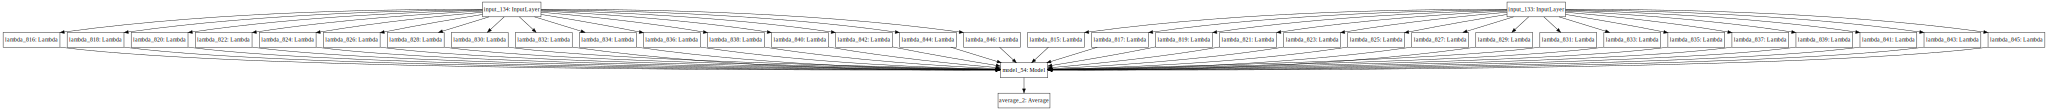

In [150]:
dis = discriminator(patch_size=64)
dis3 = discriminator3(patch_size=64)
SVG(model_to_dot(dis3).create(prog='dot', format='svg'))

In [74]:
dis.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_52 (InputLayer)            (None, 256, 256, 12)  0                                            
____________________________________________________________________________________________________
input_51 (InputLayer)            (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_265 (Lambda)              (None, 64, 64, 12)    0           input_52[0][0]                   
____________________________________________________________________________________________________
lambda_264 (Lambda)              (None, 64, 64, 3)     0           input_51[0][0]                   
___________________________________________________________________________________________

In [151]:
dis3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_134 (InputLayer)           (None, 256, 256, 12)  0                                            
____________________________________________________________________________________________________
input_133 (InputLayer)           (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_816 (Lambda)              (None, 64, 64, 12)    0           input_134[0][0]                  
____________________________________________________________________________________________________
lambda_815 (Lambda)              (None, 64, 64, 3)     0           input_133[0][0]                  
___________________________________________________________________________________________

In [187]:
def discriminator2():
    h = 256
    w = 256
    gen_output = Input(shape=(h,w,3))
    label_input = Input(shape=(h,w,12))
    x1 = CBR(32,(256,256,12), bn=False)(label_input)
    x2 = CBR(32,(256,256,3),bn=False)(gen_output)
    x = concatenate([x1,x2])
    x = CBR(128,(128,128,64))(x)
    x = CBR(256,(64,64,128))(x)
    x = CBR(512,(32,32,256))(x)
    x = Conv2D(filters=1,kernel_size=3,strides=1,padding='same')(x)
    x = Activation('softplus')(x)
    output = Lambda(lambda x: K.mean(x, axis=[1,2]),output_shape=(1,))(x)
    model = Model(inputs =[label_input,gen_output], outputs = [output])
    
    return model

In [188]:
dis2 = discriminator2()
dis2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_156 (InputLayer)           (None, 256, 256, 12)  0                                            
____________________________________________________________________________________________________
input_155 (InputLayer)           (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
sequential_215 (Sequential)      (None, 128, 128, 32)  6176        input_156[0][0]                  
____________________________________________________________________________________________________
sequential_216 (Sequential)      (None, 128, 128, 32)  1568        input_155[0][0]                  
___________________________________________________________________________________________

In [24]:
def generator():
    
    # encoder
    input1 = Input(shape=(256,256,12))
    enc_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same',input_shape=(256,256,1))(input1)
    enc_2 = CBR(128,(256,256,64))(enc_1)
    enc_3 = CBR(256,(128,128,128))(enc_2)
    enc_4 = CBR(512,(64,64,256))(enc_3)
    enc_5 = CBR(512,(32,32,512))(enc_4)
    enc_6 = CBR(512,(16,16,512))(enc_5)
    enc_7 = CBR(512,(8,8,512))(enc_6)
    enc_8 = CBR(512,(4,4,512))(enc_7)
    
    # decoder
    x = CBR(512,(2,2,512),sample='up',activation='relu',dropout=True)(enc_8)
    x = CBR(512,(4,4,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_7]))
    x = CBR(512,(8,8,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_6]))
    x = CBR(512,(16,16,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_5]))
    x = CBR(256,(32,32,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_4]))
    
    x = CBR(128,(64,64,512),sample='up',activation='relu',dropout=True)(concatenate([x,enc_3]))
    x = CBR(64,(128,128,256),sample='up',activation='relu',dropout=True)(concatenate([x,enc_2]))
    output = Conv2D(filters=3, kernel_size=(3,3),strides=1,padding="same")(concatenate([x,enc_1]))
     
    model = Model(inputs=input1, outputs=output)
    return(model)

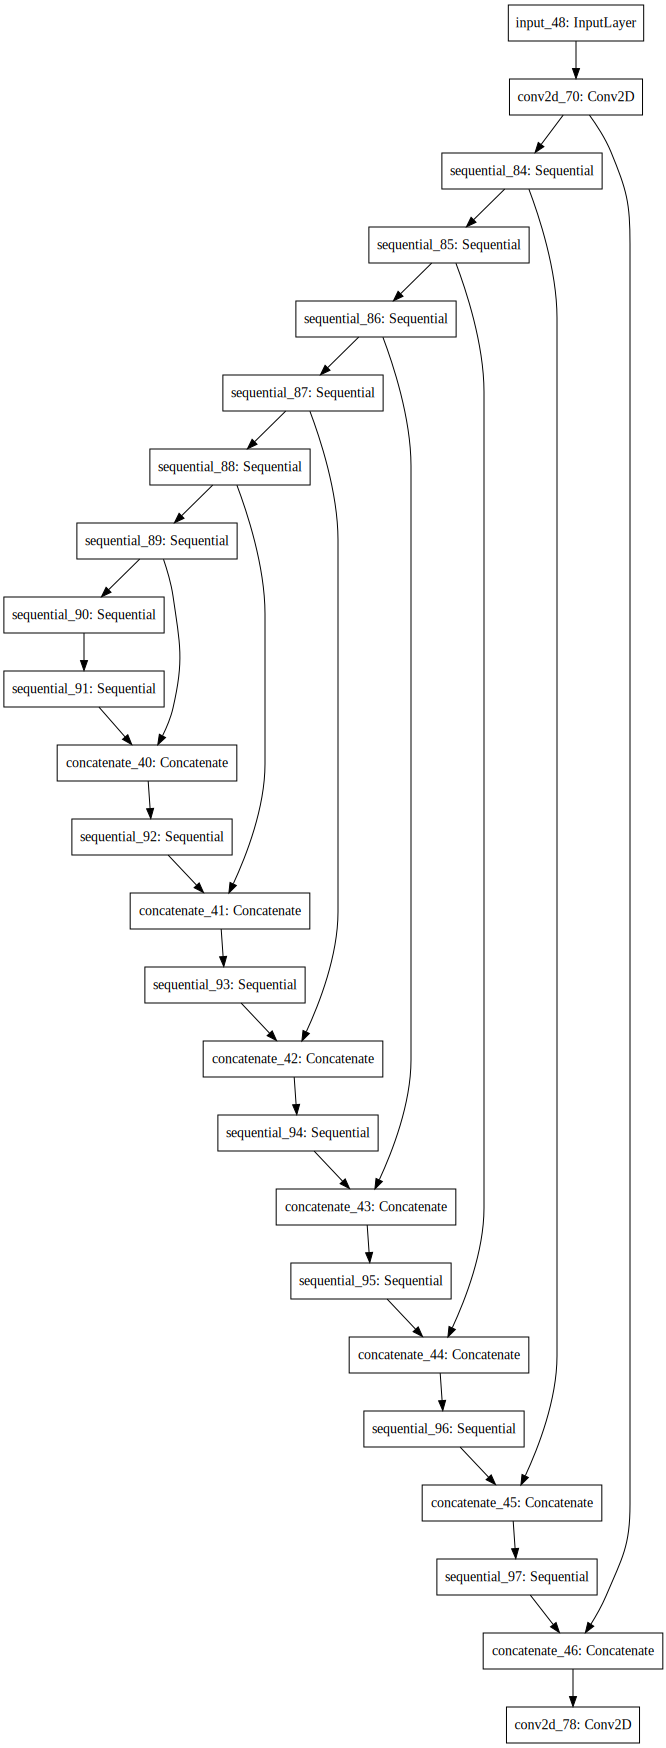

In [66]:
gen = generator()
SVG(model_to_dot(gen).create(prog='dot', format='svg'))

In [27]:
gen.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 256, 256, 12)  0                                            
____________________________________________________________________________________________________
conv2d_37 (Conv2D)               (None, 256, 256, 64)  6976        input_17[0][0]                   
____________________________________________________________________________________________________
sequential_46 (Sequential)       (None, 128, 128, 128) 131712      conv2d_37[0][0]                  
____________________________________________________________________________________________________
sequential_47 (Sequential)       (None, 64, 64, 256)   525568      sequential_46[1][0]              
___________________________________________________________________________________________

In [86]:
def GAN(generator, discriminator,  patch_size=4):

    gen_input = Input(shape=(256,256,12))
    img_input = Input(shape=(256,256,3))
    
    generated_image = generator(gen_input)


    DCGAN_output = discriminator([gen_input,img_input])

    DCGAN = Model(inputs=[gen_input,img_input],outputs=[generated_image, DCGAN_output],name="DCGAN")

    return DCGAN

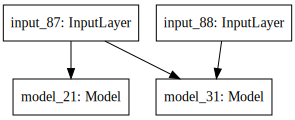

In [108]:
gan = GAN(gen,dis)
SVG(model_to_dot(gan).create(prog='dot', format='svg'))

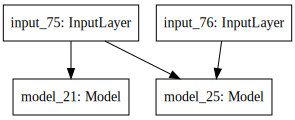

In [100]:
gan3 = GAN(gen,dis3)
SVG(model_to_dot(gan).create(prog='dot', format='svg'))

In [101]:
gan3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_77 (InputLayer)            (None, 256, 256, 12)  0                                            
____________________________________________________________________________________________________
input_78 (InputLayer)            (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
model_21 (Model)                 (None, 256, 256, 3)   54432515    input_77[0][0]                   
____________________________________________________________________________________________________
model_29 (Model)                 (None, 1)             681665      input_77[0][0]                   
                                                                   input_78[0][0]          

In [109]:
gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_87 (InputLayer)            (None, 256, 256, 12)  0                                            
____________________________________________________________________________________________________
input_88 (InputLayer)            (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
model_21 (Model)                 (None, 256, 256, 3)   54432515    input_87[0][0]                   
____________________________________________________________________________________________________
model_31 (Model)                 (None, 1)             681682      input_87[0][0]                   
                                                                   input_88[0][0]          

In [103]:
train_img = train_d[0]
train_label = train_d[1]

In [110]:
gan_pre = gan.predict([train_label[0:10],train_img[0:10]])
print(gan_pre[1])

[[ 0.59468937]
 [ 0.59493363]
 [ 0.59619355]
 [ 0.59256303]
 [ 0.59507954]
 [ 0.59478706]
 [ 0.59418118]
 [ 0.59324527]
 [ 0.593095  ]
 [ 0.59442854]]


In [97]:
gan3_pre = gan3.predict([train_label[0:10],train_img[0:10]])

In [111]:
gan_pre[1].shape

(10, 1)

In [112]:
gan3_pre[1].shape

(10,)

In [116]:
label_batch = train_label[0:10]
print(label_batch.shape)
img_batch = train_img[0:10]
print(img_batch.shape)

(10, 256, 256, 12)
(10, 256, 256, 3)


In [133]:
dis_pre = dis.predict([label_batch,img_batch])
print(dis_pre)

[[ 0.36671534]
 [ 0.35717022]
 [ 0.35868531]
 [ 0.36623576]
 [ 0.35845044]
 [ 0.36601251]
 [ 0.35733426]
 [ 0.36109984]
 [ 0.36404479]
 [ 0.36784494]]


In [189]:
dis2_pre = dis2.predict([label_batch,img_batch])
print(dis2_pre)

[[ 0.69276667]
 [ 0.6956287 ]
 [ 0.69081032]
 [ 0.69122964]
 [ 0.69144821]
 [ 0.69191396]
 [ 0.69461775]
 [ 0.69339305]
 [ 0.69047546]
 [ 0.69004327]]


In [180]:
np.mean(dis2_pre[0][1])

0.69366574

In [127]:
dis3.layers[-1].output
dis3.layers[-2].output

<tf.Tensor 'concatenate_58/concat:0' shape=(?, 16) dtype=float32>

In [135]:
dis3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_94 (InputLayer)            (None, 256, 256, 12)  0                                            
____________________________________________________________________________________________________
input_93 (InputLayer)            (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_493 (Lambda)              (None, 64, 64, 12)    0           input_94[0][0]                   
____________________________________________________________________________________________________
lambda_492 (Lambda)              (None, 64, 64, 3)     0           input_93[0][0]                   
___________________________________________________________________________________________

In [34]:
import tensorflow as tf
sess = K.get_session()
y_true = tf.Variable(np.array([1.0] * 10))
y_pred = tf.Variable(gan_pre[1].astype(np.float64))
init_run = tf.global_variables_initializer()
sess.run(init_run)
sess.run(K.binary_crossentropy(y_pred,y_true))

array([ 0.65612213,  0.68433921,  0.65129178,  0.64833497,  0.71087927,
        0.6989115 ,  0.67093874,  0.64975921,  0.68461941,  0.71110687])

In [191]:
from keras.optimizers import Adam, SGD
opt_discriminator = Adam(lr=1E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
dis2.compile(loss="binary_crossentropy", optimizer=opt_discriminator)    

In [192]:
dis_y = [1] * 5 + [0] * 5
dis2.train_on_batch([train_label[0:10],train_img[0:10]],dis_y)

0.71597588